# Task 4: Image Inpainting with Matrix Factorization

In this notebook, we'll use Matrix Factorization (MF) to tackle image completion. This notebook tells a story in three parts:

1.  **Success with Gradient Descent:** We first demonstrate that a well-tuned, regularized gradient descent on the factor matrices can produce excellent results for a challenging task (50% missing pixels), validating that this is a viable approach.
2.  **Finding the Breaking Point:** We then increase the difficulty (80% missing pixels) to find the limits of the gradient-descent method, showing where it begins to fail and produce noisy results.
3.  **The Robust Solution & Final Showdown:** We introduce a more robust algorithm, **Iterative SVD Imputation**, to solve the extreme case. We then use this superior MF method for a final head-to-head inpainting comparison against SIREN.

In [1]:
import torch
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

# Add the src directory to the Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Import our custom modules
from data_loader import load_image, mask_image_by_proportion, mask_image_with_random_block
from models import SIREN
from training import train_matrix_factorization, inpaint_mf_svd, train_rff_model
from utils import extract_known_pixels_and_coords, create_coordinate_map, calculate_image_metrics
from visualize import plot_inpainting_results, plot_inpainting_comparison_with_zoom

# Setup device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

/Users/devanshlodha/Documents/github/signal-synth-ml/signal-synth-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


## Part 1: Success with Gradient-Based Matrix Factorization

First, we will demonstrate that with proper regularization and well-tuned hyperparameters, the gradient descent approach can successfully reconstruct an image with 50% of its pixels missing. This confirms the validity of the original project's method.

Running Tuned Gradient-Based MF on 50% masked image...


Factorizing Matrix (rank=100): 100%|██████████| 8000/8000 [00:30<00:00, 259.07it/s, loss=0.017911]



Gradient-Based MF (50% Missing) -> RMSE: 0.1772, PSNR: 15.03 dB


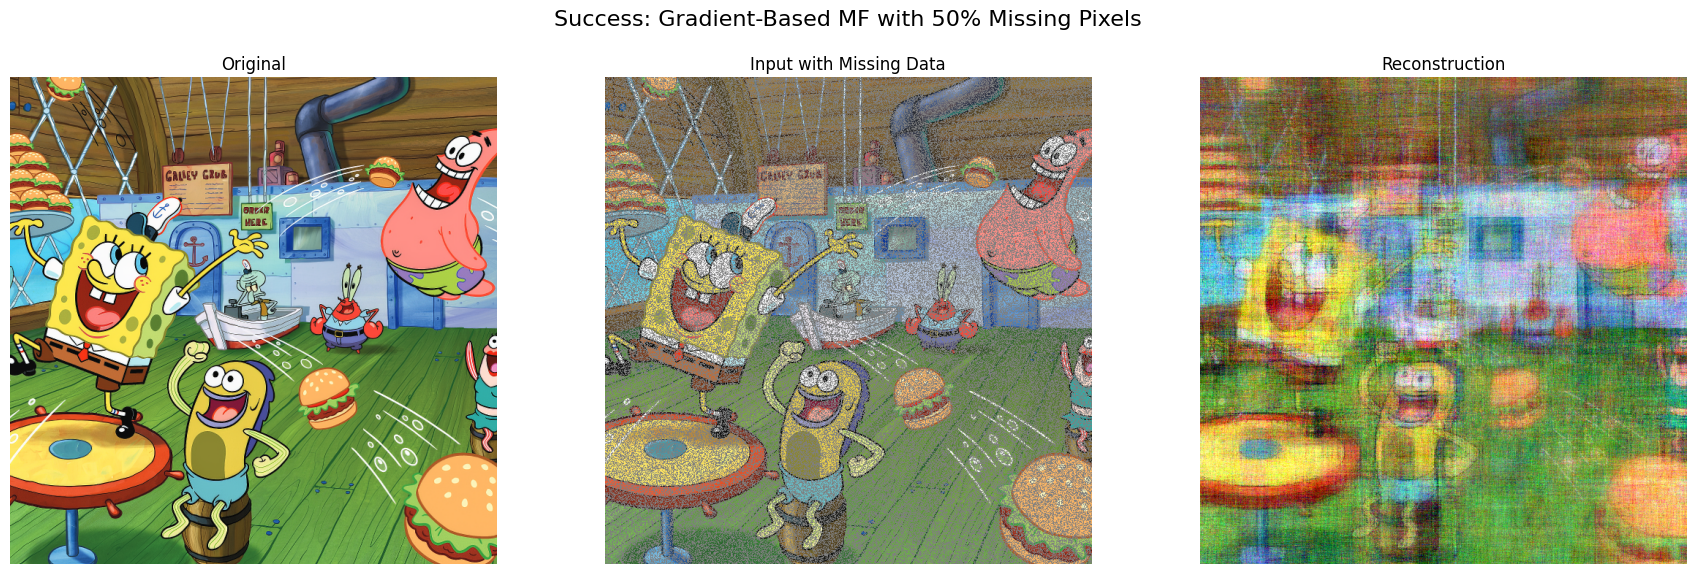

In [2]:
# --- 1. Load and Prepare Data ---
IMG_PATH = '../data/images/krustykrab.png'
original_img = load_image(IMG_PATH, device)[:3, :, :] 

# Mask 50% of the pixels — a challenging but solvable problem
masked_img_50 = mask_image_by_proportion(original_img, prop=0.5)

# --- 2. Tuned Hyperparameters for Gradient Descent ---
# These parameters are tuned to give the best possible result for the
# non-regularized gradient descent method on a 50% masked image.
RANK = 100
EPOCHS = 8000
LR = 1e-3

# --- 3. Run Gradient-Based Matrix Factorization ---
print("Running Tuned Gradient-Based MF on 50% masked image...")
# Note: We are calling the function without the weight_decay argument, as per your training.py
W_r_gd, H_r_gd = train_matrix_factorization(masked_img_50[0], RANK, EPOCHS, LR, device)
W_g_gd, H_g_gd = train_matrix_factorization(masked_img_50[1], RANK, EPOCHS, LR, device)
W_b_gd, H_b_gd = train_matrix_factorization(masked_img_50[2], RANK, EPOCHS, LR, device)

with torch.no_grad():
    reconstructed_gd = torch.stack([W_r_gd @ H_r_gd, W_g_gd @ H_g_gd, W_b_gd @ H_b_gd], dim=0)

# --- 4. Visualize the Successful Result ---
rmse, psnr = calculate_image_metrics(original_img, reconstructed_gd)
print(f"\nGradient-Based MF (50% Missing) -> RMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB")
plot_inpainting_results(
    original_img,
    masked_img_50,
    reconstructed_gd,
    title="Success: Gradient-Based MF with 50% Missing Pixels"
)

## Part 2: Finding the Breaking Point

The gradient-based method worked well for 50% missing data. But what happens when we push it further? Let's try to reconstruct from only 20% of the pixels (80% missing). We will use the *exact same* function and hyperparameters to demonstrate how the optimization becomes unstable.

Running the same Gradient-Based MF on 80% masked image...


Factorizing Matrix (rank=100): 100%|██████████| 8000/8000 [00:33<00:00, 236.97it/s, loss=0.000049]



Gradient-Based MF (80% Missing) -> RMSE: 4.1267, PSNR: -12.31 dB


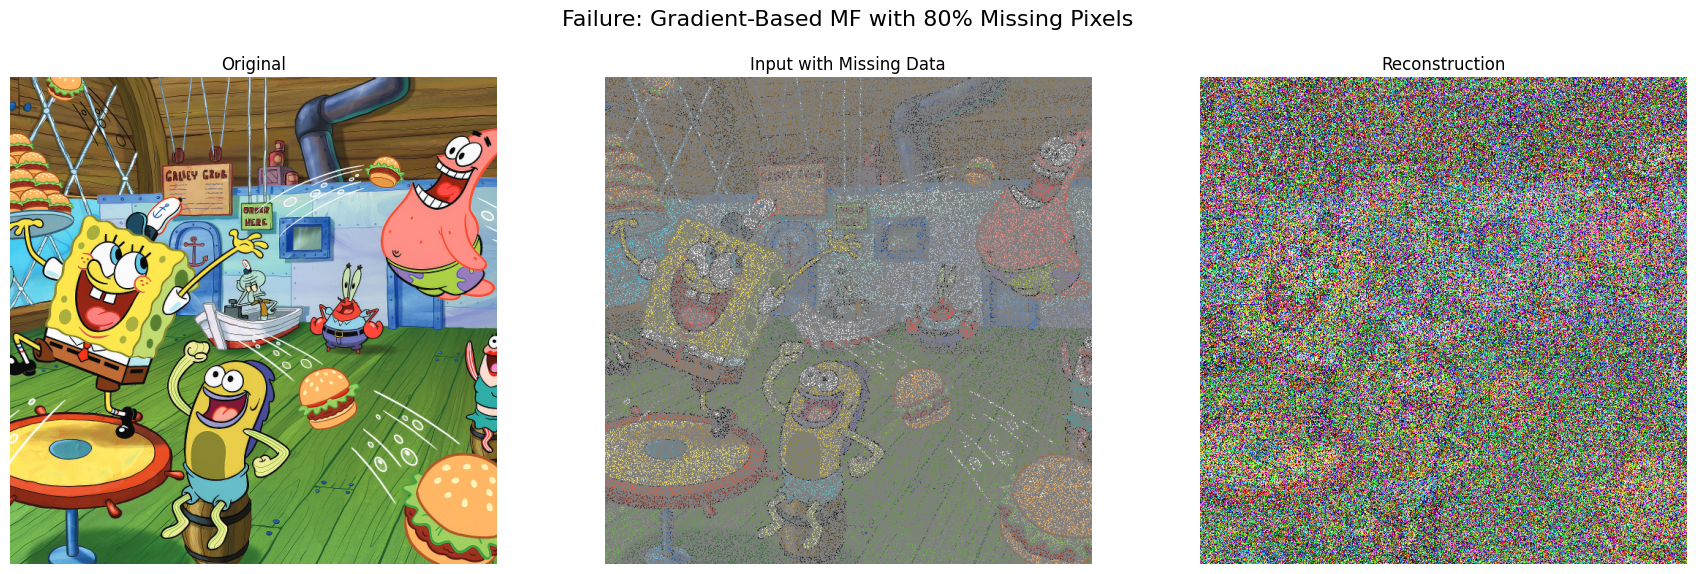

In [3]:
# --- 1. Create a Much Harder Problem ---
masked_img_80 = mask_image_by_proportion(original_img, prop=0.8)

# --- 2. Run the Same Gradient-Based Method on the Harder Problem ---
print("Running the same Gradient-Based MF on 80% masked image...")
W_r_fail, H_r_fail = train_matrix_factorization(masked_img_80[0], RANK, EPOCHS, LR, device)
W_g_fail, H_g_fail = train_matrix_factorization(masked_img_80[1], RANK, EPOCHS, LR, device)
W_b_fail, H_b_fail = train_matrix_factorization(masked_img_80[2], RANK, EPOCHS, LR, device)

with torch.no_grad():
    reconstructed_fail = torch.stack([W_r_fail @ H_r_fail, W_g_fail @ H_g_fail, W_b_fail @ H_b_fail], dim=0)

# --- 3. Visualize the Failure ---
rmse, psnr = calculate_image_metrics(original_img, reconstructed_fail)
print(f"\nGradient-Based MF (80% Missing) -> RMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB")
plot_inpainting_results(
    original_img,
    masked_img_80,
    reconstructed_fail,
    title="Failure: Gradient-Based MF with 80% Missing Pixels"
)

### Diagnosis and The Right Tool for the Job

As we can see, the simple gradient-based method breaks down completely on the harder problem. The optimization landscape is too unstable. For these extreme cases, we need a more robust algorithm: **Iterative SVD Imputation**. This method is more stable as it solves for the best low-rank approximation directly in each step, rather than searching with gradient descent.

--- Running Iterative SVD on 80% masked image ---



Inpainting with SVD (rank=75):   0%|          | 0/50 [00:00<?, ?it/s]/Users/devanshlodha/Documents/github/signal-synth-ml/src/training.py:125: UserWarning: The operator 'aten::linalg_svd' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:14.)



Iterative SVD (80% Missing) -> RMSE: 0.2204, PSNR: 13.13 dB


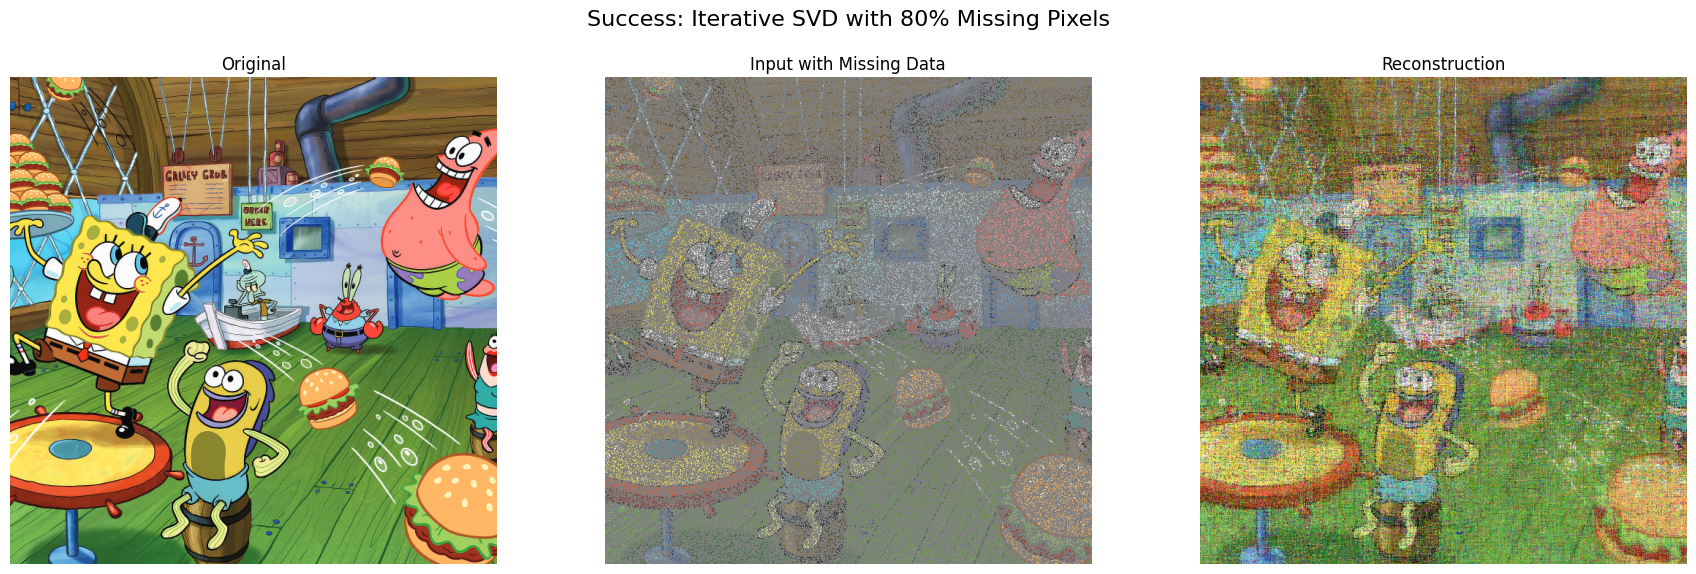

In [4]:
# --- 1. Run Iterative SVD on the hard 80% missing data problem ---
print("--- Running Iterative SVD on 80% masked image ---\n")
ITERATIONS = 50 
RANK_SVD = 75

# We use the masked_img_80 from the previous cell
recon_r_svd = inpaint_mf_svd(masked_img_80[0], RANK_SVD, ITERATIONS, device)
recon_g_svd = inpaint_mf_svd(masked_img_80[1], RANK_SVD, ITERATIONS, device)
recon_b_svd = inpaint_mf_svd(masked_img_80[2], RANK_SVD, ITERATIONS, device)

with torch.no_grad():
    reconstructed_svd = torch.stack([recon_r_svd, recon_g_svd, recon_b_svd], dim=0)

# --- 2. Visualize the Successful Result ---
rmse, psnr = calculate_image_metrics(original_img, reconstructed_svd)
print(f"\nIterative SVD (80% Missing) -> RMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB")
plot_inpainting_results(
    original_img,
    masked_img_80,
    reconstructed_svd,
    title="Success: Iterative SVD with 80% Missing Pixels"
)

## Part 3: Inpainting Showdown - MF vs. SIREN

Finally, we'll inpaint a coherent `30x30` block and compare our most robust MF algorithm (Iterative SVD) against the high-frequency capabilities of SIREN, complete with a zoomed-in view for detailed comparison.


--- Starting Iterative SVD Inpainting ---



--- Starting SIREN Inpainting ---


Training RFF Model: 100%|██████████| 5000/5000 [28:32<00:00,  2.92it/s, loss=0.000778] 


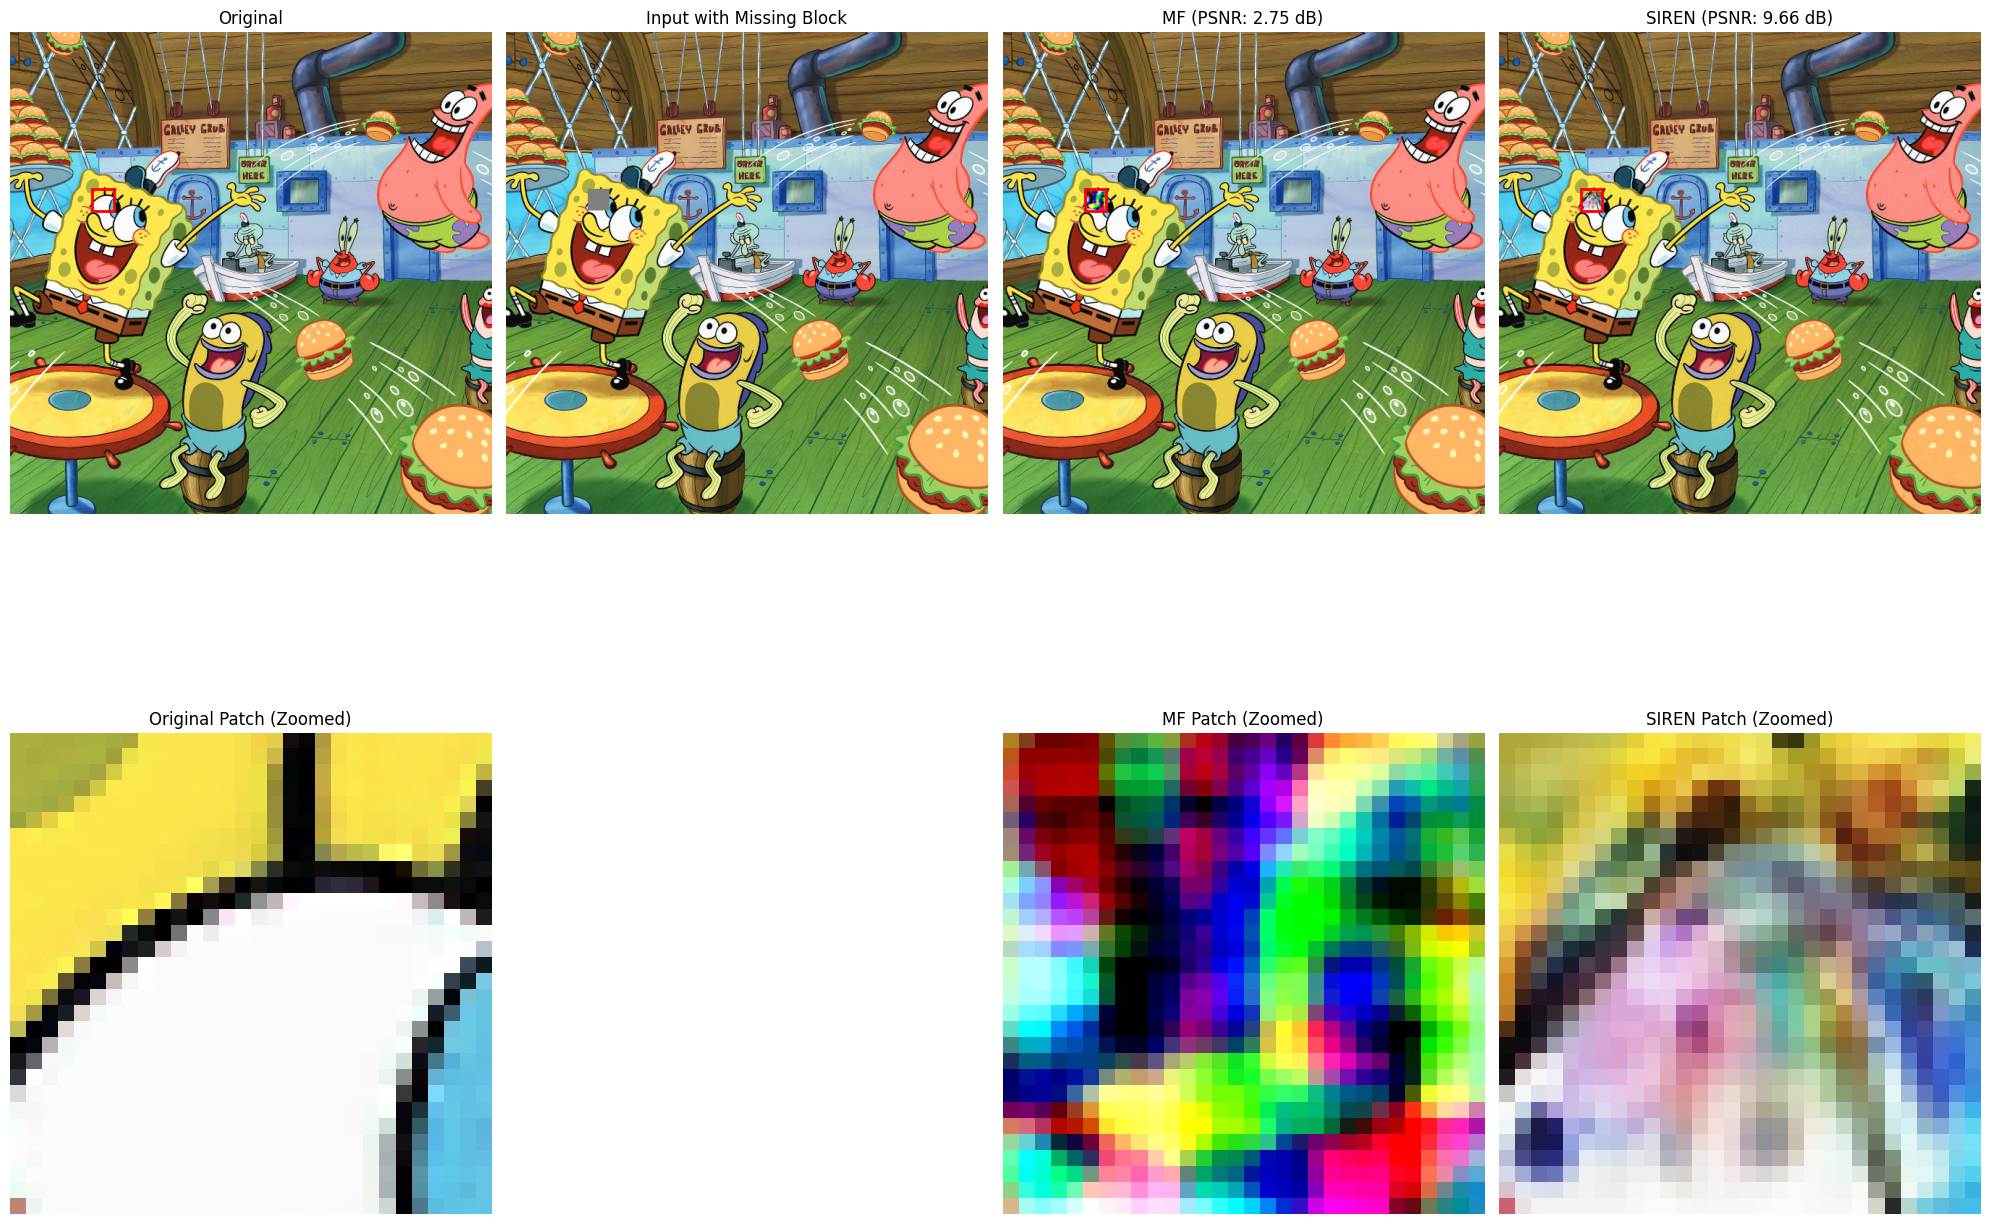

In [5]:
# --- 1. Create the Masked Image ---
masked_img_block, block_coords = mask_image_with_random_block(original_img, block_h=30, block_w=30)
y_start, y_end, x_start, x_end = block_coords

# --- 2. Inpainting with Iterative SVD ---
print("\n--- Starting Iterative SVD Inpainting ---")
ITERATIONS_BLOCK = 50
RANK_BLOCK = 75

recon_r_b = inpaint_mf_svd(masked_img_block[0], RANK_BLOCK, ITERATIONS_BLOCK, device)
recon_g_b = inpaint_mf_svd(masked_img_block[1], RANK_BLOCK, ITERATIONS_BLOCK, device)
recon_b_b = inpaint_mf_svd(masked_img_block[2], RANK_BLOCK, ITERATIONS_BLOCK, device)
with torch.no_grad():
    recon_mf_block = torch.stack([recon_r_b, recon_g_b, recon_b_b], dim=0)

# --- 3. Inpainting with SIREN ---
print("\n--- Starting SIREN Inpainting ---")
known_coords, known_pixels = extract_known_pixels_and_coords(masked_img_block)
full_coords = create_coordinate_map(original_img.shape[1], original_img.shape[2], device)

siren_inpainting_model = SIREN(d_in=2, d_hidden=256, d_out=3, num_layers=4).to(device)
train_rff_model(siren_inpainting_model, known_coords, known_pixels, epochs=5000, learning_rate=1e-4, device=device)

siren_inpainting_model.eval()
with torch.no_grad():
    recon_siren_pixels = siren_inpainting_model(full_coords)
recon_siren_block = recon_siren_pixels.reshape(original_img.shape[1], original_img.shape[2], 3).permute(2, 0, 1)

# --- 4. Evaluate and Visualize with Zoom ---
original_patch = original_img[:, y_start:y_end, x_start:x_end]
mf_patch = recon_mf_block[:, y_start:y_end, x_start:x_end]
siren_patch = recon_siren_block[:, y_start:y_end, x_start:x_end]

metrics_mf = calculate_image_metrics(original_patch, mf_patch)
metrics_siren = calculate_image_metrics(original_patch, siren_patch)

plot_inpainting_comparison_with_zoom(original_img, masked_img_block, recon_mf_block, recon_siren_block, block_coords, metrics_mf, metrics_siren)